# Курсовой проект

## Постановка задачи
### Задача
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
#### Наименование файлов с данными
course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет
#### Целевая переменная
Credit Default - факт невыполнения кредитных обязательств
#### Метрика качества
F1-score (sklearn.metrics.f1_score)
#### Требования к решению
Целевая метрика  
F1 > 0.5  
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)  
Решение должно содержать  
### Задание
#### Построение модели классификации
1 Обзор обучающего датасета  
2 Обработка выбросов  
3 Обработка пропусков  
4 Анализ данных  
5 Отбор признаков  
6 Балансировка классов  
7 Подбор моделей, получение бейзлана  
8 Выбор наилучшей модели, настройка гиперпараметров  
9 Проверка качества, борьба с переобучением  
10 Интерпретация результатов  
#### Прогнозирование на тестовом датасете
1 Выполнить для тестового датасета те же этапы обработки и постронияния признаков  
2 Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете  
3 Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)  
4 Соблюдать исходный порядок примеров из тестового датасета  
#### Описание датасета
- Home Ownership - домовладение
- Annual Income - годовой доход
- Years in current job - количество лет на текущем месте работы
- Tax Liens - налоговые обременения
- Number of Open Accounts - количество открытых счетов
- Years of Credit History - количество лет кредитной истории
- Maximum Open Credit - наибольший открытый кредит
- Number of Credit Problems - количество проблем с кредитом
- Months since last delinquent - количество месяцев с последней просрочки платежа
- Bankruptcies - банкротства
- Purpose - цель кредита
- Term - срок кредита
- Current Loan Amount - текущая сумма кредита
- Current Credit Balance - текущий кредитный баланс
- Monthly Debt - ежемесячный долг
- Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Импорт библиотек

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import catboost as catb
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def balance_df_by_target(df, target_name):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

In [4]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

In [5]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train = pd.read_csv(TRAIN_DATASET_PATH)

### Обзор и обработка обучающего датасета

In [6]:
df_train.shape

(7500, 17)

In [7]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

Столбцы NaN: (Years in current job, Months since last delinquent) - должны находиться числа.

In [8]:
HOME_OWNERSHIP='Home Ownership'
ANNUAL_INCOME='Annual Income' # КОНСТАНТЫ НАЗВАНЫ ПО ИМЕНАМ СТОЛБЦОВ
YEARS_IN_CURRENT_JOB='Years in current job'
TAX_LIENS='Tax Liens'
NUMBER_OF_OPEN_ACCOUNTS='Number of Open Accounts'
YEARS_OF_CREDIT_HISTORY='Years of Credit History'
MAXIMUM_OPEN_CREDIT='Maximum Open Credit'
NUMBER_OF_CREDIT_PROBLEMS='Number of Credit Problems'
MONTHS_SINCE_LAST_DELINQUENT='Months since last delinquent'
BANKRUPTCIES='Bankruptcies'
PURPOSE='Purpose'
TERM='Term'
CURRENT_LOAN_AMOUNT='Current Loan Amount'
CURRENT_CREDIT_BALANCE='Current Credit Balance'
MONTHLY_DEBT='Monthly Debt'
CREDIT_SCORE='Credit Score'
CREDIT_DEFAULT='Credit Default'

In [9]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [10]:
df_train.isna().sum(axis=0)

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [11]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


1 Purpose,Term --в dummies  
2 Home Ownership КАТЕГОРИАЛЬНЫЙ ПРИЗНАК - МЕНЯЮ В dummies.  
3 Current Loan Amount ВЫБРОСЫ -- МЕНЯЮ НА СРЕДНЕЕ.  
4 Bankruptcies: NaN меняю на 0  
5 Months since last delinquent - NaN меняю на 0  
6 Credit Score: NaN меняю средним/нулем/медианой  
7 Annual Income: NaN -- МЕНЯЮ модой/средним.      
8 Years in current job ЧИСЛОВОЙ ПРИЗНАК - МЕНЯЮ NaN и 10+ в моду/ноль СЛОВО 'years' УДАЛЯЮ.      

In [12]:
def process_data(dataframe):
    new_dataframe = dataframe.copy()
    # 1, 2
    new_dataframe.loc[new_dataframe[TERM] == 'Short Term', TERM] = '0'
    new_dataframe.loc[new_dataframe[TERM] == 'Long Term', TERM] = '1'
    new_dataframe[TERM] = new_dataframe[TERM].astype("int8")
    new_dataframe[PURPOSE] = new_dataframe[PURPOSE].astype("category")
    new_dataframe[HOME_OWNERSHIP] = new_dataframe[HOME_OWNERSHIP].astype("category")
    new_dataframe = pd.get_dummies(new_dataframe, columns=[HOME_OWNERSHIP, PURPOSE])
    # 3
    outlier_value = 99999999.0
    temp_df = new_dataframe[new_dataframe[CURRENT_LOAN_AMOUNT] < outlier_value]
    new_dataframe.loc[new_dataframe[CURRENT_LOAN_AMOUNT] == outlier_value, CURRENT_LOAN_AMOUNT] = temp_df[CURRENT_LOAN_AMOUNT].mean()
    # 4
    new_dataframe.loc[new_dataframe[BANKRUPTCIES].isna() == True, BANKRUPTCIES] = 0
    # 5
    new_dataframe.loc[new_dataframe[MONTHS_SINCE_LAST_DELINQUENT].isna() == True, MONTHS_SINCE_LAST_DELINQUENT] = new_dataframe[MONTHS_SINCE_LAST_DELINQUENT].median()
    # 6
    new_dataframe.loc[new_dataframe[CREDIT_SCORE].isna() == True, CREDIT_SCORE] = new_dataframe[CREDIT_SCORE].mean()
    # 7
    new_dataframe.loc[new_dataframe[ANNUAL_INCOME].isna(), ANNUAL_INCOME] = new_dataframe[ANNUAL_INCOME].mean()
    # 8
    # - Сначала вырезаем из имеющихся значений все, что не является цифрой
    new_dataframe[YEARS_IN_CURRENT_JOB].replace(to_replace=r'[^\d]+', value='', inplace=True, regex=True)
    # - Заменяем все NaN на '999'
    new_dataframe.loc[new_dataframe[YEARS_IN_CURRENT_JOB].isna() == True, YEARS_IN_CURRENT_JOB] = '999'
    # - Меняем тип столбца на int
    new_dataframe[YEARS_IN_CURRENT_JOB] = new_dataframe[YEARS_IN_CURRENT_JOB].astype(int)
    # - Заменяем все 0 на среднее значение
    new_dataframe.loc[new_dataframe[YEARS_IN_CURRENT_JOB] == 999, YEARS_IN_CURRENT_JOB] = int(new_dataframe[YEARS_IN_CURRENT_JOB].median())
    return new_dataframe

In [13]:
df_train = process_data(df_train)
df_train.dtypes

Annual Income                   float64
Years in current job              int32
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Term                               int8
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
Home Ownership_Have Mortgage      uint8
Home Ownership_Home Mortgage      uint8
Home Ownership_Own Home           uint8
Home Ownership_Rent               uint8
Purpose_business loan             uint8
Purpose_buy a car                 uint8
Purpose_buy house                 uint8
Purpose_debt consolidation        uint8
Purpose_educational expenses      uint8
Purpose_home improvements         uint8


## Анализируем данные

In [14]:
df_train.corr()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
Annual Income,1.000000e+00,0.090250,0.058466,0.167589,0.166076,0.021275,-0.013705,-0.057988,-0.059775,0.086228,...,0.067335,-0.001405,0.024973,-0.016365,-0.019412,6.595040e-19,-0.002397,-0.014554,0.005745,0.034698
Years in current job,9.025005e-02,1.000000,0.016510,0.052480,0.220813,0.002883,0.046896,-0.001592,0.055079,0.070289,...,0.029488,-0.023851,0.006758,-0.025094,-0.028221,2.578452e-03,-0.003986,-0.005337,-0.022376,-0.009989
Tax Liens,5.846638e-02,0.016510,1.000000,-0.005360,0.009109,-0.002410,0.595339,0.051208,0.057423,0.004953,...,-0.003049,0.018838,0.029712,-0.004252,0.005114,-1.812103e-03,-0.006544,-0.007812,-0.003626,-0.004967
Number of Open Accounts,1.675893e-01,0.052480,-0.005360,1.000000,0.144819,0.023897,-0.017813,-0.015721,-0.018859,0.071316,...,-0.004404,-0.000834,-0.013548,-0.010250,-0.069763,-8.753762e-03,0.002124,-0.035607,0.015771,-0.012138
Years of Credit History,1.660758e-01,0.220813,0.009109,0.144819,1.000000,0.029247,0.071259,0.002169,0.085592,0.044243,...,0.041071,-0.015546,0.024181,-0.011921,-0.007881,1.607943e-02,0.000466,-0.021714,-0.002807,-0.007104
Maximum Open Credit,2.127477e-02,0.002883,-0.002410,0.023897,0.029247,1.000000,-0.004750,-0.002220,-0.011632,-0.006023,...,0.001611,-0.001960,-0.002672,-0.001552,0.002771,-7.200307e-04,-0.002066,0.042426,-0.001180,-0.000872
Number of Credit Problems,-1.370497e-02,0.046896,0.595339,-0.017813,0.071259,-0.004750,1.000000,0.113736,0.730808,-0.020433,...,0.021080,0.008078,0.008092,0.000908,-0.002869,-5.568904e-03,-0.020111,0.002710,0.054400,-0.009278
Months since last delinquent,-5.798789e-02,-0.001592,0.051208,-0.015721,0.002169,-0.002220,0.113736,1.000000,0.109866,0.009826,...,-0.008307,-0.009599,-0.001887,-0.003437,-0.006899,-5.251286e-03,-0.000758,0.000593,0.016997,-0.002722
Bankruptcies,-5.977484e-02,0.055079,0.057423,-0.018859,0.085592,-0.011632,0.730808,0.109866,1.000000,-0.030981,...,0.035129,0.001703,-0.005169,0.007169,-0.014551,-5.505538e-03,-0.019882,-0.001791,0.000760,-0.015091
Term,8.622792e-02,0.070289,0.004953,0.071316,0.044243,-0.006023,-0.020433,0.009826,-0.030981,1.000000,...,0.030995,0.002640,-0.007551,-0.014719,-0.038929,8.974924e-03,0.016881,-0.024278,-0.010008,-0.006048


In [15]:
TARGET_NAME = CREDIT_DEFAULT
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

0 > 1 ТРЕБУЕТСЯ БАЛАНСИРОВКА КЛАССОВ

КОРЕРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВЫМ:

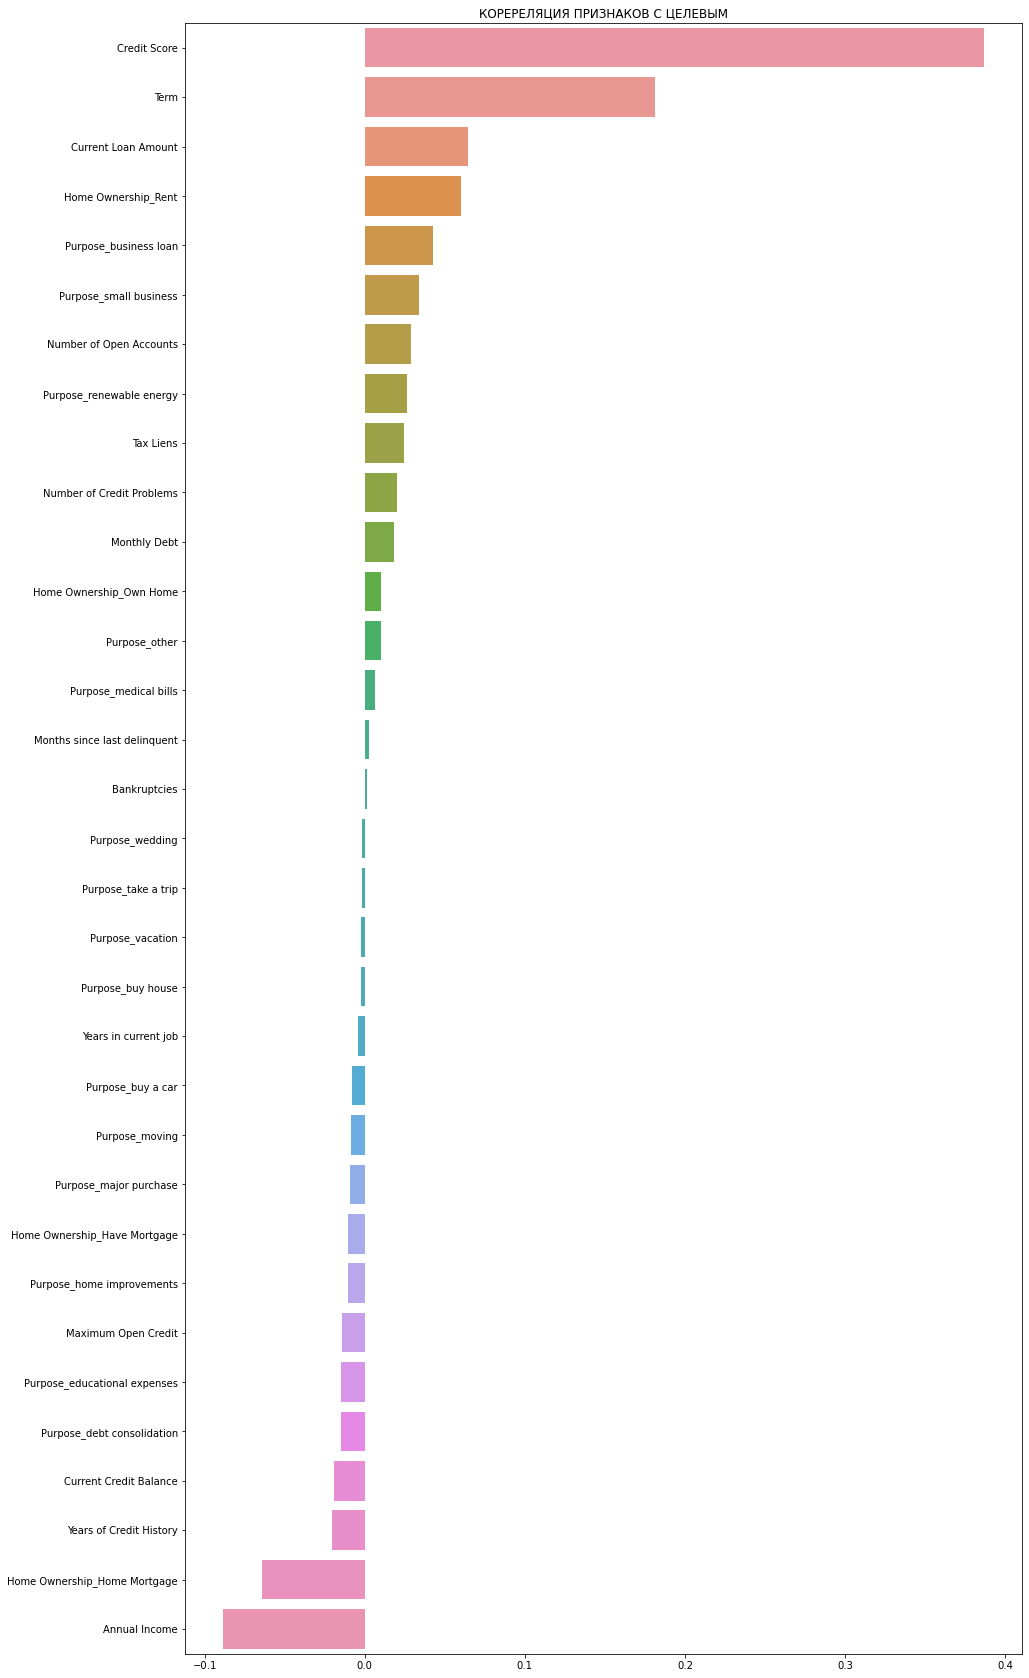

In [16]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(15, 30))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('КОРЕРЕЛЯЦИЯ ПРИЗНАКОВ С ЦЕЛЕВЫМ')
plt.show()

ПРЕДИКТОРЫ: Credit Score, Term, Current Loan Amount, Home Ownership_Rent, Annual Income, Home Ownership_Home Mortgag

МАТРИЦА КОРРЕЛЯЦИЙ

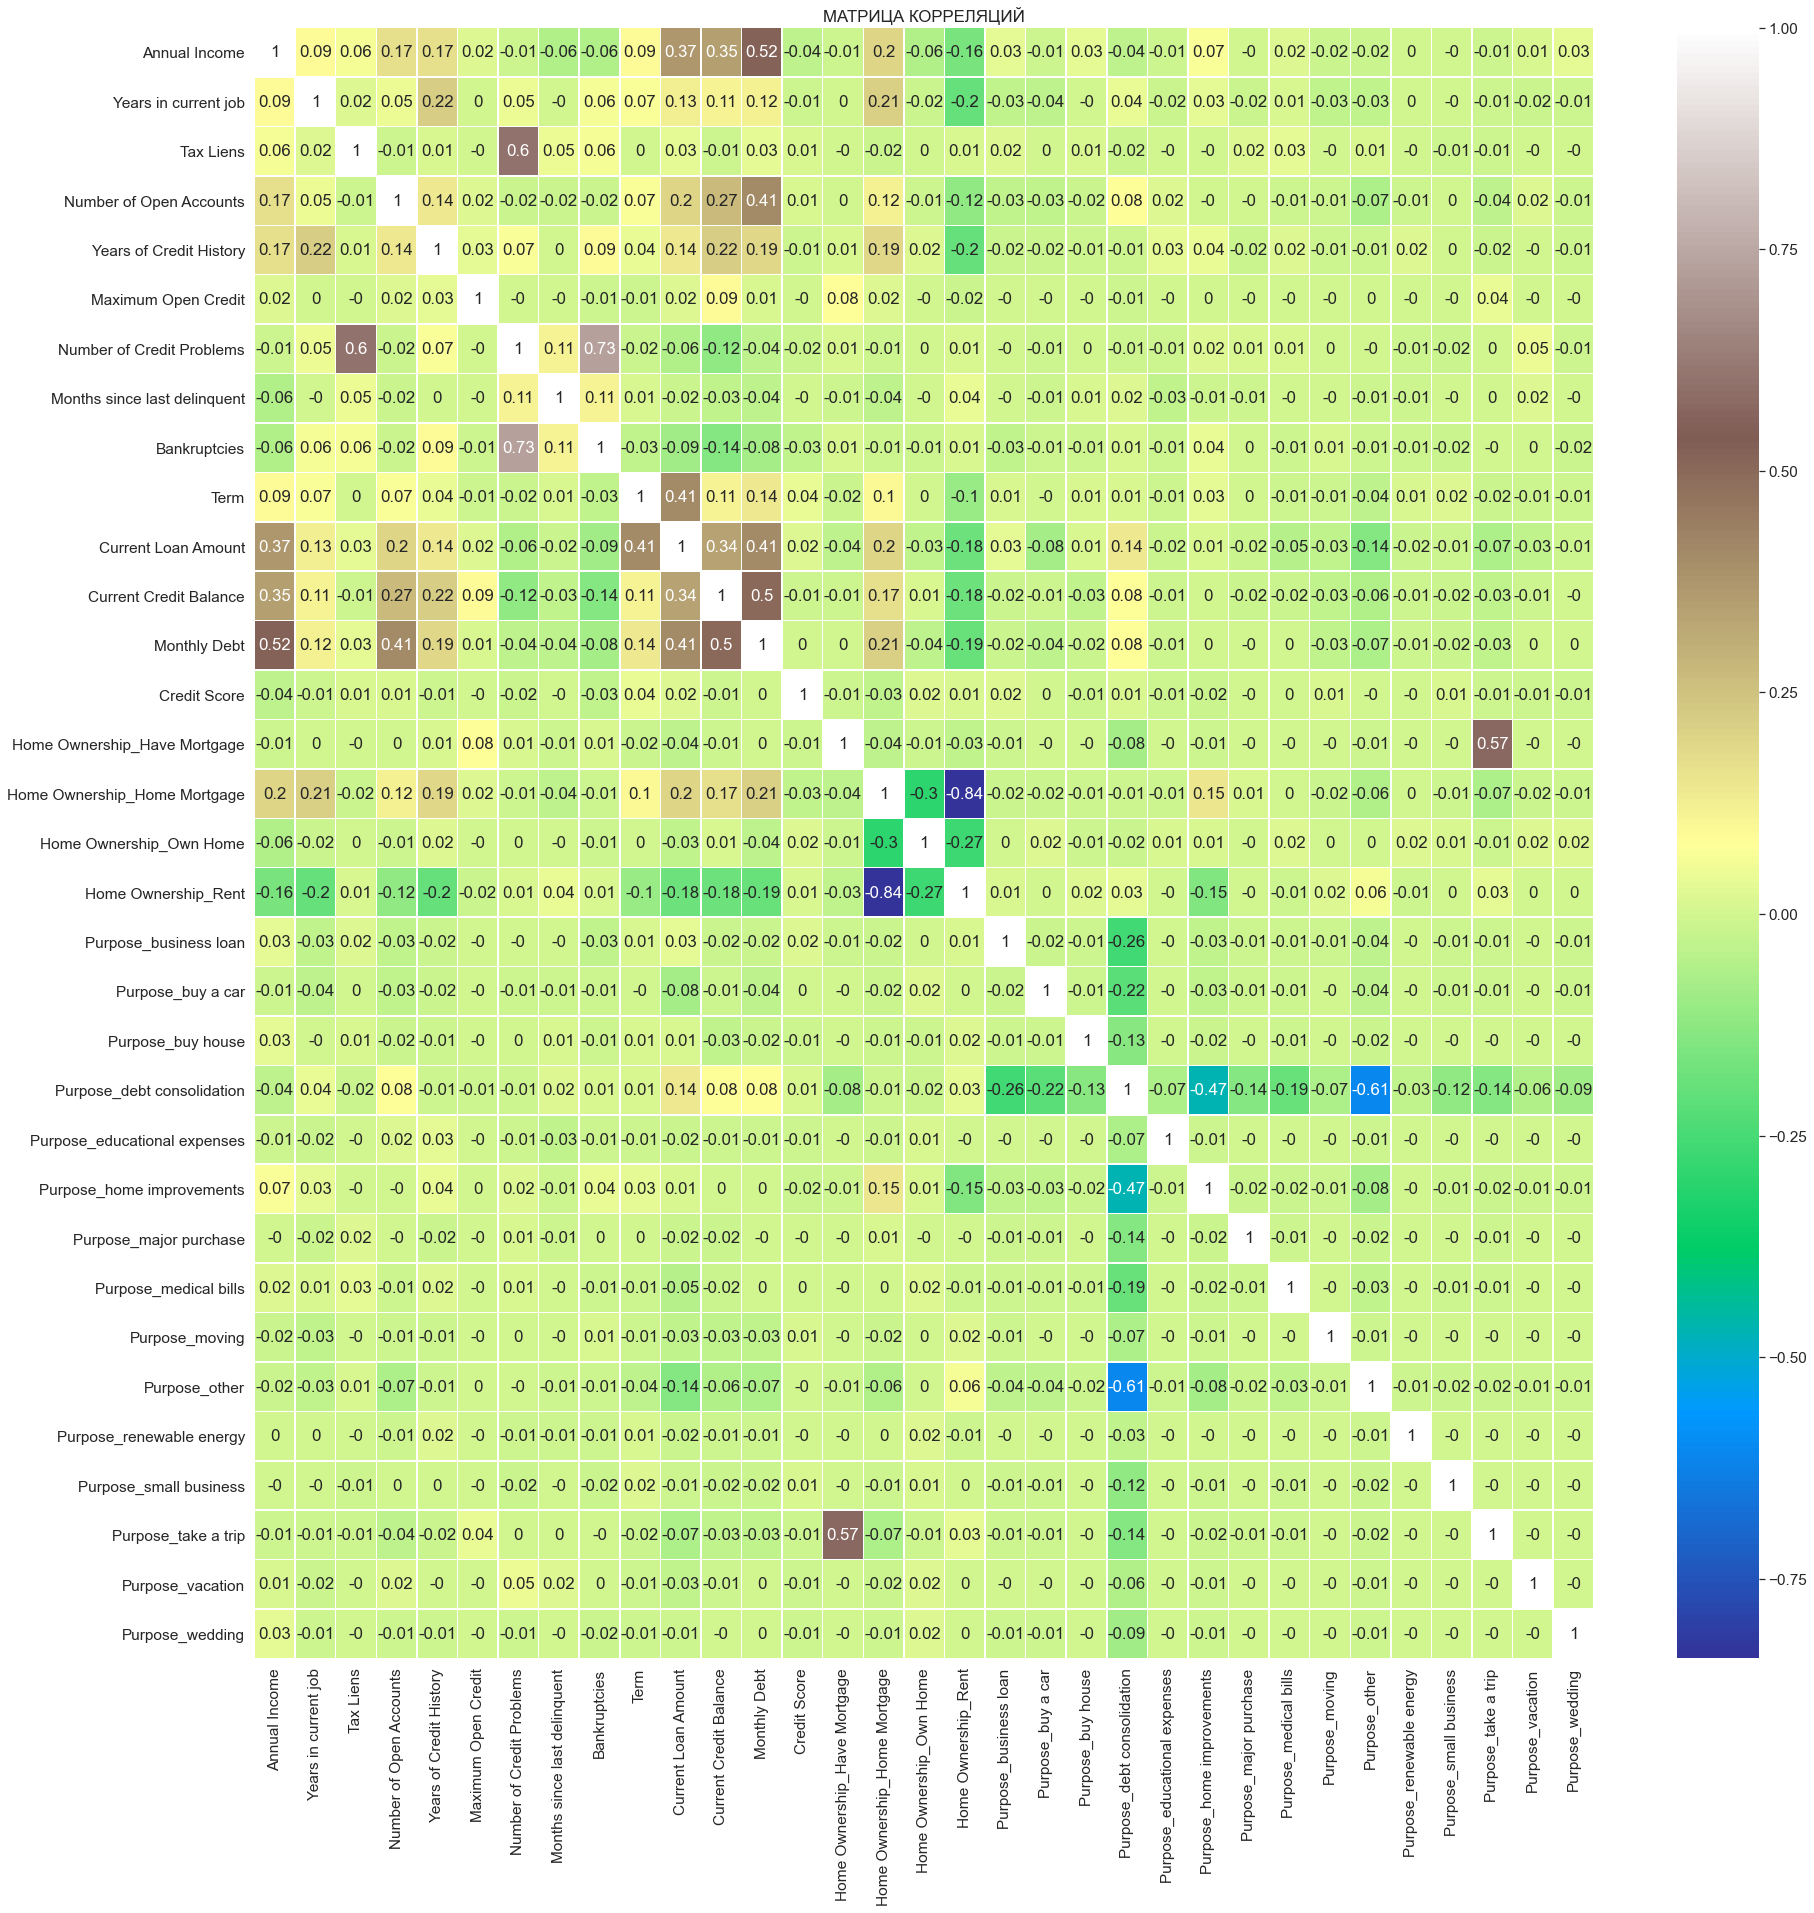

In [17]:
plt.figure(figsize = (30,30))
sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(2), annot=True, linewidths=.5, cmap='terrain')
plt.title('МАТРИЦА КОРРЕЛЯЦИЙ')
plt.show()

- Высокая корреляция между признаками Bankruptcies, Number of Credit Problems  
- Bankruptcies не коррелирует с целевой переменной, можно его исключить

### Отбор признаков

In [18]:
SELECTED_FEATURE_NAMES = [
    CREDIT_SCORE,
    CURRENT_LOAN_AMOUNT, 
    ANNUAL_INCOME, 
    TERM, 
    'Home Ownership_Rent', 
    'Home Ownership_Home Mortgage',
    'Purpose_small business',
    'Number of Open Accounts',
    'Purpose_renewable energy',
    'Tax Liens',
    'Number of Credit Problems',
    'Monthly Debt',
    'Years of Credit History',
    'Current Credit Balance',
    'Purpose_debt consolidation',
    'Purpose_educational expenses'
]

NUM_FEATURE_NAMES = [
    ANNUAL_INCOME,
    YEARS_IN_CURRENT_JOB,
    TAX_LIENS, 
    NUMBER_OF_OPEN_ACCOUNTS,
    YEARS_OF_CREDIT_HISTORY,
    MAXIMUM_OPEN_CREDIT,
    NUMBER_OF_CREDIT_PROBLEMS,
    MONTHS_SINCE_LAST_DELINQUENT,
    BANKRUPTCIES,
    TERM,
    CURRENT_LOAN_AMOUNT,
    CURRENT_CREDIT_BALANCE,
    MONTHLY_DEBT,
    CREDIT_SCORE
]

#### НОРМАЛИЗАЦИЯ ДАННЫХ

In [19]:
def normalize_dataframe(dataframe, numeric_feature_names):
    scaler = StandardScaler()
    df_norm = dataframe.copy()
    df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
    return df_norm

In [20]:
df_norm = normalize_dataframe(df_train, NUM_FEATURE_NAMES)
df_norm

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-1.175263,0.011333,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.083484,2.545732,-0.591517,...,0,0,0,0,0,0,0,0,0,0
1,-0.453071,1.183681,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.083484,-0.337099,1.690569,...,0,0,0,0,0,0,0,0,0,0
2,-0.817324,0.597507,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.083484,-0.337099,-0.591517,...,0,0,0,0,0,0,0,0,0,0
3,-0.746014,0.011333,-0.110953,-0.637847,0.593985,-0.049781,1.664779,-0.083484,2.545732,-0.591517,...,0,0,0,0,0,0,0,0,0,0
4,-0.784295,0.597507,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.083484,-0.337099,-0.591517,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.281446,-1.454103,-0.110953,-1.656468,-1.394234,-0.052248,-0.340979,-0.083484,-0.337099,-0.591517,...,0,0,0,0,1,0,0,0,0,0
7496,0.222734,-1.454103,-0.110953,-0.230398,1.162048,-0.016152,-0.340979,0.664664,-0.337099,1.690569,...,0,0,0,0,0,0,0,0,0,0
7497,0.681150,0.011333,-0.110953,0.177050,1.957336,0.052029,-0.340979,-0.083484,-0.337099,-0.591517,...,0,0,0,0,0,0,0,0,0,0
7498,0.000000,0.011333,-0.110953,2.010568,1.162048,0.012237,-0.340979,-0.083484,-0.337099,-0.591517,...,0,0,0,0,0,0,0,0,0,0


### Балансировка целевой переменной

In [21]:
df_balanced = balance_df_by_target(df_norm, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

### Обучение модели

In [22]:
X = df_balanced[SELECTED_FEATURE_NAMES]
y = df_balanced[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
params = {'n_estimators': [50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth': [3, 5, 7]}
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [23]:
%%time
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=1)
rs.fit(X, y)

Wall time: 1min 20s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000022C4BEB6F70>,
                   n_jobs=1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [24]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 7}

In [25]:
rs.best_score_

0.7077769664316972

In [26]:
%%time
final_model = catb.CatBoostClassifier(n_estimators=rs.best_params_['n_estimators'], 
                                      max_depth=rs.best_params_['max_depth'],
                                      silent=True, 
                                      random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)# Измеряю качество обучения

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3753
           1       0.95      0.85      0.89      2976

    accuracy                           0.91      6729
   macro avg       0.92      0.90      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.77      0.84      0.81      1634
           1       0.77      0.68      0.72      1250

    accuracy                           0.77      2884
   macro avg       0.77      0.76      0.76      2884
weighted avg       0.77      0.77      0.77      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1377  257
1                402  848
Wall time: 4.84 s


### ПРЕДСКАЗАНИЕ

In [27]:
df_test_processed = process_data(df_test)
df_test_normalized = normalize_dataframe(df_test_processed, NUM_FEATURE_NAMES)
columns = [CREDIT_SCORE] + list(filter(lambda feature: feature != CREDIT_SCORE, SELECTED_FEATURE_NAMES))
# Таких целей нет в выборке для предсказания, поэтому добавляю хардкодом, но вообще это можно автоматизировать
df_test_normalized['Purpose_renewable energy'] = 0 
df_test_rearranged = df_test_normalized[columns]
y_test_predict = final_model.predict(df_test_normalized)
df_test[CREDIT_DEFAULT] = y_test_predict
y_test_predict

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

In [28]:
df_test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN,0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0,1
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0,0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN,1
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,1
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,0


In [29]:
df_test.to_csv('SHIPKOV_A_V_predictions.csv')